Post process 3D bbx tracking data produced in April 2021
Goals
1. rectify 3D bbox measurements into comprehensible trajecotry data for enhancing training
2. manual validate the rectified measurements with the videos

Tasks
1. compute homography matrix (done)
2. transform bottom 4 poitns into real-world coords (done)
3. work on the road plane (done)
4. use optimization to rectify measurements (done)
5. add motion (velocity. acceleration) constraints in optimization (done)
6. optimization switch direction south/north bound
6. Apply Joint Probabilistic Data Association algorithm (JPDA)
    https://stonesoup.readthedocs.io/en/latest/auto_tutorials/08_JPDATutorial.html
    a. one object has 4 measurements

In [1]:
from utils import *
import importlib
import utils
importlib.reload(utils)
import os.path
from os import path
import pandas as pd
import utils_optimization as opt
importlib.reload(opt)
import time
from scipy.optimize import minimize,NonlinearConstraint,leastsq,fmin_slsqp,least_squares
import numpy.linalg as LA


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
data_path = pathlib.Path().absolute().joinpath('../2D-3D May 2021')
file_name = 'rectified_dynamics/rectified_p2c2.csv'
file_path = data_path.joinpath(file_name)
tform_path = data_path.joinpath('camera_calibration_points_I24_validation_system.csv')
df = utils.read_data(file_path)


In [267]:
# debug direction -1
# unpack variables
timestamps = Y1['Timestamp'].values
timestamps= utils.nan_helper(timestamps)
dt = np.diff(timestamps)

# get bottom 4 points coordinates
pts = ['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']
pts_gps = ['bbrlat','bbrlon', 'fbrlat','fbrlon','fbllat','fbllon','bbllat', 'bbllon']
Y1 = np.array(Y1[pts])

# Euler forward dynamics
N = len(Y1) 
notNan = ~np.isnan(np.sum(Y1,axis=-1))
Y1 = Y1[notNan,:]
a0 = np.zeros((N))
v0 = (Y1[-1,0]-Y1[0,0])/(timestamps[notNan][-1]-timestamps[notNan][0])

sign = np.sign(v0)
v0 = np.abs(v0)
x0 = (Y1[0,0]+Y1[0,6])/2
y0 = (Y1[0,1]+Y1[0,7])/2
theta = np.ones((N))*np.arccos(sign)
w = np.nanmean(np.abs(Y1[:,1]-Y1[:,7]))
l = np.nanmean(np.abs(Y1[:,0]-Y1[:,2]))
v = np.zeros(N)
v[0] = v0
for k in range(0,N-2):
    v[k+1] = v[k] + a[k]*dt[k]
v[-1]=v[-2]

vx = v*cos(theta)
vy = v*sin(theta)

x = np.zeros(N)
y = np.zeros(N)
x[0] = x0
y[0] = y0

for k in range(0,N-1):
    x[k+1] = x[k] + vx[k]*dt[k]
    y[k+1] = y[k] + vy[k]*dt[k]

# compute positions
xa = x + w/2*sin(theta)
ya = y - w/2*cos(theta)
xb = xa + l*cos(theta)
yb = ya + l*sin(theta)
xc = xb - w*sin(theta)
yc = yb + w*cos(theta)
xd = xa - w*sin(theta)
yd = ya + w*cos(theta)
Yre = np.stack([xa,ya,xb,yb,xc,yc,xd,yd],axis=-1)


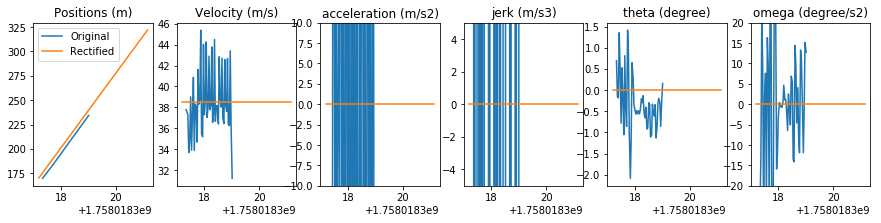

In [59]:
import utils
importlib.reload(utils)
# cx = (Y1[:,0]+Y1[:,6])/2
# cy = (Y1[:,1]+Y1[:,7])/2

fig, (ax1, ax2, ax3, ax4, ax5,ax6) = plt.subplots(1, 6, figsize=(15,3))

ax1.plot(timestamps[notNan], Y1[:,0], label='Original')
ax1.plot(timestamps, Yre[:,0] , label='Rectified')
ax1.legend()
ax1.set_title('Positions (m)')
    
_,_,v1 = utils.calc_vel(Y1, timestamps[notNan])
# _,_,vre = utils.calc_vel(Yre,timestamps)
# v1 = np.diff(Y1[:,0], append=Y1[-1,0])
# vre = np.diff(Yre[:,0], append=Yre[-1,0])
ax2.plot(timestamps[notNan], v1, label='Original velocity')
ax2.plot(timestamps, v , label='Rectified velocity')
ax2.set_title('Velocity (m/s)')

a1 = utils.calc_accel(Y1[:,0], timestamps[notNan])
# are = utils.calc_accel(Yre[:,0],timestamps)
# a1 = np.diff(v1, append=v1[-1])
# are = np.diff(vre, append=vre[-1])
ax3.plot(timestamps[notNan], a1, label='Original accel')
ax3.plot(timestamps, a , label='Rectified accel')
ax3.set_title('acceleration (m/s2)')
ax3.set_ylim([-10,10])

# j1 = np.diff(a1, append=a1[-1])
# jre = np.diff(are, append=are[-1])
j1 = np.gradient(a1,timestamps[notNan])
jre = np.gradient(a, timestamps)
ax4.plot(timestamps[notNan], j1)
ax4.plot(timestamps, jre)
ax4.set_title('jerk (m/s3)')
ax4.set_ylim([-5,5])

theta1 = utils.calc_theta(Y1, timestamps[notNan])
# thetare = utils.calc_theta(Yre,timestamps)
ax5.plot(timestamps[notNan], np.degrees(theta1))
ax5.plot(timestamps, np.degrees(theta))
ax5.set_title('theta (degree)')

thetaddot1 = np.gradient(theta1,timestamps[notNan])
# thetaddotre = np.gradient(np.gradient(thetare)/dt)/dt
# theta1 = np.diff(a1, append=a1[-1])
# jre = np.diff(are, append=are[-1])
ax6.plot(timestamps[notNan], np.degrees(thetaddot1))
ax6.plot(timestamps, np.degrees(omega))
ax6.set_title('omega (degree/s2)')
ax6.set_ylim([-20,20])
plt.show()

In [7]:
# least squares formulation just about the same run time and results
# try calculating the gradient of objective function
# optimize on the road plane
# a formulation that accounts for heading change (for lane changing)
# try having simplified decision variables and no constraints


start = time.time()


p_dim = 2  # lp norm
p = 1

dt = np.gradient(timestamps)
lam1 = 1
lam2 = 0 # regularize acceleration 100
lam3 = 10 # regularize jerk
lam4 = 100 # regularize on thetaddot
lam5 = 100
N = len(Y1)
global lam1, lam2, lam3, lam4, dt, Y1, timestamps, N

def obj(X):
    """The cost function
        X = [cx, cy, theta, w, l]^T
    """    
    cx = X[:N]
    cy = X[N:2*N]
    theta = X[2*N:3*N]
    w = X[3*N]
    l = X[3*N+1]
    
    # compute positions
    xa = cx + w/2*sin(theta)
    ya = cy - w/2*cos(theta)
    xb = xa + l*cos(theta)
    yb = ya + l*sin(theta)
    xc = xb - w*sin(theta)
    yc = yb + w*cos(theta)
    xd = xa - w*sin(theta)
    yd = ya + w*cos(theta)
    Yre = np.stack([xa,ya,xb,yb,xc,yc,xd,yd],axis=-1) 
    
    # min perturbation
    c1 = lam1*np.sum((Y1-Yre)**2)
    
#     # jerk regularization
#     v = np.gradient(cx,timestamps)/cos(theta)
#     a = np.gradient(v,timestamps)
#     j = np.gradient(a,timestamps)
#     c3 = lam3 * np.sum(j**2)

#     # theta ddot regularization
#     thetaddot = np.gradient(np.gradient(theta)/dt)/dt
#     c4 = lam4 * np.sum(thetaddot**2)
# #     print(c1,c3,c4)

#     # pfaffian constraint
#     vx = np.gradient(cx)/dt
#     vy = np.gradient(cy)/dt
#     c5 = lam5*np.sum((-vx*sin(theta)+vy*cos(theta))**2)
#     print(c1,c3,c4,c5)
    return c1 

def const5(X):
    # Pfaffian constraint
    cx = X[:N]
    cy = X[N:2*N]
    theta = X[2*N:3*N]

    vx = np.gradient(cx)/dt
    vy = np.gradient(cy)/dt
    return -vx*sin(theta)+vy*cos(theta)
    
#     return np.sum(c5**2)
nlc = ({"type": "eq", "fun": const5})
# initial values
cx0 = (Y1[:,0]+Y1[:,6])/2
cy0 = (Y1[:,1]+Y1[:,7])/2
w0 = 1
l0 = 4
theta0 = np.zeros((N))
X0 = np.concatenate((cx0.T, cy0.T, theta0, [w0,l0]), axis=0)
bnds = [(0,np.inf) for i in range(0,2*N)]+[(-np.pi/8,np.pi/8) for i in range(len(theta0))]+[(1,4),(2,50)]
list1, list2 = zip(*bnds)
bnd_list = (list(list1),list(list2))

# Constraints definition (only for COBYLA, SLSQP and trust-constr)
res = minimize(obj, X0, method = 'L-BFGS-B',
                bounds=bnds, options={'disp': False,'maxiter':100000})#
# BFGS: fast,ok
# L-BFGS-B: really fast, ok results
# CG: slow, ok
# COBLYA: fast but results no good
# SLSQP and fmin_slsqp: inequality cosntraints incompatible
# res = fmin_slsqp(obj, X0, # inequality constraint not compatible
#                 bounds=bnds, disp= True, iter=1000)
# res = least_squares(obj, X0, # super slow
#                 bounds=bnd_list, verbose = 2)
# res = shgo(obj,bounds=bnds)
end = time.time()
print(end - start)
# extract results
cx = res.x[:N]
cy = res.x[N:2*N]
theta = res.x[2*N:3*N]
w = res.x[3*N]
l = res.x[3*N+1]

Yre = utils.calc_positions(cx,cy,theta,w,l)
print(w,l)

0.3485264778137207
1.3014620637148426 4.276270081179986


In [84]:
# ver1: slow but accurate
# optimize on the road plane
# returns sigular matrix (constraints not continuous) if using equality constraints
import time

start = time.time()
from scipy.optimize import minimize,NonlinearConstraint
import numpy.linalg as LA
p_dim = 2  # lp norm
p = 1


lam = 0.001 # regularize acceleration
lam2 = 0.0001 # regularize jerk
global lam, lam2, dt, Y1, timestamps

def obj(X):
    """The cost function"""   
#     global Yre, w, l
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
#     
    # min perturbation
    c1 = LA.norm(Y1-Yre,2)

    # acceleration regularization
    dx = np.gradient(Yre[:,0])
    v = dx/dt
    a = np.gradient(v)/dt
    c2 = lam * LA.norm(a,2)
    
    # jerk regularization
    j = np.gradient(a)/dt
    c3 = lam2 * LA.norm(j,2)
    return c1 + c2 + c3

def const1(X):
    # l, l, w, w, squared
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
    return 0.0001-np.sum((Yre[:,[2,4,3,1]]-Yre[:,[0,6,5,7]]-np.array([l,l,w,w]))**2)
#     return (Yre[:,[2,4,3,1]]-Yre[:,[0,6,5,7]]-np.array([l,l,w,w]))**2
          
def const2(X):
    # rectangle shape constraint
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
    return 0.0001-np.sum((Yre[:,[1,7,2,0]]-Yre[:,[3,5,4,6]])**2)
#     return (Yre[:,[1,7,2,0]]-Yre[:,[3,5,4,6]]).flatten('F')
                  
def const3(X):
    # follow straight lines movement and widthes are parallel to lanes
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
    return 0.1 - np.std(Yre[:,3]) - np.std(Yre[:,1]) - np.std(Yre[:,5]) - np.std(Yre[:,7])
#     return np.std(Yre[:,3]) + np.std(Yre[:,1]) + np.std(Yre[:,5]) + np.std(Yre[:,7])


nlc = ({"type": "ineq", "fun": const1},
       {"type": "ineq", "fun": const2},
       {"type": "ineq", "fun": const3})
Y1f = Y1.flatten('F')
X0 = np.append(Y1f,[2.2, 4])
bnds = [(0,np.inf) for i in range(0,len(X0)-2)]+[(1,3),(2,np.inf)]

res = minimize(obj, X0, method='SLSQP', 
               constraints=nlc,
               bounds=bnds, options={'disp': True, 'maxiter':1000})
end = time.time()
print(end - start)

X_data = res.x[:-2]
w = res.x[-2]
l = res.x[-1]
Yre = np.reshape(X_data,(-1,len(Y1))).T

print(w,l)


Iteration limit exceeded    (Exit mode 9)
            Current function value: 13.814819920458618
            Iterations: 1001
            Function evaluations: 290232
            Gradient evaluations: 998
104.13162207603455
1.000000000000086 4.313711616444018
